## Muhamed Mustafa Muhamed ALi - AI - G2
### Machine Learning I - ( Project - Head Pose Estimation )


### Installing MediaPipe

In [ ]:
%%capture
!pip install mediapipe

### Required Libraries

In [ ]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
np.random.seed(0)

### Dowlining Data

In [ ]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [ ]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

### Looping on Images

In [ ]:
x_array1 = []
y_array1 = []
pitch_array1 = []
yaw_array1 = []
roll_array1 = []
i=0

# extracting the file names (2000 name)
file_names = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")])
# detecting faces and extracting the points
faceModule = mediapipe.solutions.face_mesh

# looping over the file names to load the images and their corresponding mat file
for file in file_names:
  # i+=1
  # if i < 100:
        # loading image and its correspinding mat file
        with faceModule.FaceMesh(static_image_mode=True) as faces:
            # loading the image
            image = cv2.imread('/content/AFLW2000/'+file+'.jpg')
            # processing the face to extract the landmark points (468 point) for each x,y,z
            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks != None: 
              # looping over the faces in the image
              for face in results.multi_face_landmarks:
                  # initializing two lists to store the points for every face.
                  x_arrsmall1 =[]
                  y_arrsmall1 =[]
                  # looping over the 468 points of x and y
                  for landmark in face.landmark:
                      x = landmark.x
                      y = landmark.y
                      # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                      shape = image.shape 
                      relative_x = int(x * shape[1])
                      relative_y = int(y * shape[0])
                      #Xs of every face
                      x_arrsmall1.append(relative_x)
                      #Ys of every face
                      y_arrsmall1.append(relative_y)
                  # converting the lists to numpy arrays
                  x_arrsmall = np.array(x_arrsmall1)
                  y_arrsmall = np.array(y_arrsmall1)
                  # appending the points of every face in the list of all image points
                  x_array1.append(x_arrsmall)
                  y_array1.append(y_arrsmall)
                  # converting the lists to numpy arrays
                  x_array = np.array(x_array1)
                  y_array = np.array(y_array1)

                  #cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0,255,0), 2)
                  #cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
                  # cv2_imshow(image)

                  # loading the mat file to extract the labels (pitch,yaw,roll)
                  mat_file = sio.loadmat('/content/AFLW2000/'+file+'.mat')
                  # extracting the labels 3 angels
                  pose_para = mat_file["Pose_Para"][0][:3]
                  # the first label (pitch)
                  pitch = pose_para[0]
                  # the second label (yaw)
                  yaw = pose_para[1]
                  # the third label (roll)
                  roll = pose_para[2]
                  # appending the angle of every face in 3 lists
                  pitch_array1.append(pitch)
                  yaw_array1.append(yaw)
                  roll_array1.append(roll)
        # converting the lists to numpy arrays
        pitch_array = np.array(pitch_array1)
        yaw_array = np.array(yaw_array1)
        roll_array = np.array(roll_array1)

        #cv2_imshow(draw_axis(image,pitch,yaw,roll))
     
print(x_array.shape)
print(y_array.shape)
print(pitch_array.shape)
print(yaw_array.shape)
print(roll_array.shape)

(1853, 468)
(1853, 468)
(1853,)
(1853,)
(1853,)


###Preprocessing the data


In [ ]:
# center 99
# Top of Head = 10
# Bottom of Head = 171

# centering the data arround the 99th point 
x_center = x_array - x_array[:,99].reshape(-1,1)
y_center = y_array - y_array[:,99].reshape(-1,1)

# normalizing the data to be in the same scale by dividing over the distance between point 10 and point 171
x_171 = x_array[:,171]
x_10 = x_array[:,10]
y_171 = y_array[:,171]
y_10 = y_array[:,10]

# computing the distance
distance = np.linalg.norm(np.array((x_10,y_10)) - np.array((x_171,y_171)),axis = 0).reshape(-1,1)
x_norm = x_center / distance
y_norm = y_center / distance

print(x_norm.shape)
print(y_norm.shape)

# concatinating the X and Y points to form the compelete features
features = np.hstack([x_norm,y_norm])

print(features.shape)

(1853, 468)
(1853, 468)
(1853, 936)


In [ ]:
# concatenating the Xs and Ys to features array
features = np.hstack((x_norm,y_norm))
print(features.shape)

# concatenating the features and pitch angel to dataset_pitch array
dataset_pitch = np.hstack((features,pitch_array.reshape(-1,1)))
print(dataset_pitch.shape)

# concatenating the features and yaw angel to dataset_yaw array
dataset_yaw = np.hstack((features,yaw_array.reshape(-1,1)))
print(dataset_yaw.shape)

# concatenating the features and roll angel to dataset_roll array
dataset_roll = np.hstack((features,roll_array.reshape(-1,1)))
print(dataset_roll.shape)

# concatenating the 3 angels to labels array
labels = np.hstack((pitch_array.reshape(-1,1),yaw_array.reshape(-1,1),roll_array.reshape(-1,1)))
print(labels.shape)

(1853, 936)
(1853, 937)
(1853, 937)
(1853, 937)
(1853, 3)


In [ ]:
# Split data to 2 parts train(70%) and validation(30%)
x_train, x_vali, y_train, y_vali = train_test_split(features, labels, test_size=0.3, random_state=0)

###XGBoost Model


In [ ]:
#First Model for Pitch angle
xg_param = {'n_estimators': np.arange(5,9,2),'max_depth': np.arange(1,7,2),'learning_rate': np.arange(0.4,0.8,0.2)}
m_xgb_pitch = XGBRegressor(random_state=0,verbosity=0)
m_gs_xgb_pitch = GridSearchCV(m_xgb_pitch,xg_param)
m_gs_xgb_pitch.fit(x_train,y_train[:,0])
m_gs_xgb_pitch_be = m_gs_xgb_pitch.best_estimator_
y_xgb_train_pitch = m_gs_xgb_pitch_be.predict(x_train)
y_xgb_pred_pitch = m_gs_xgb_pitch_be.predict(x_vali)

print(f"XGB Best Estimator of Pitch angle : {m_gs_xgb_pitch_be}")
print(f"XGB Train Error of Pitch angle : {mean_absolute_error(y_train[:,0],y_xgb_train_pitch)}")
print(f"XGB Train Validation of Pitch angle : {mean_absolute_error(y_vali[:,0],y_xgb_pred_pitch)}")

XGB Best Estimator of Pitch angle : XGBRegressor(learning_rate=0.4, max_depth=1, n_estimators=5, verbosity=0)
XGB Train Error of Pitch angle : 0.17542730594175396
XGB Train Validation of Pitch angle : 0.21761405290047997


In [ ]:
#Second Model for Yaw angle
xg_param = {'n_estimators': np.arange(5,9,2),'max_depth': np.arange(1,7,2),'learning_rate': np.arange(0.4,0.8,0.2)}
m_xgb_yaw = XGBRegressor(random_state=0,verbosity=0)
m_gs_xgb_yaw = GridSearchCV(m_xgb_yaw,xg_param)
m_gs_xgb_yaw.fit(x_train,y_train[:,1])
m_gs_xgb_yaw_be = m_gs_xgb_yaw.best_estimator_
y_xgb_train_yaw = m_gs_xgb_yaw_be.predict(x_train)
y_xgb_pred_yaw = m_gs_xgb_yaw_be.predict(x_vali)

print(f"XGB Best Estimator of yaw angle : {m_gs_xgb_yaw_be}")
print(f"XGB Train Error of yaw angle : {mean_absolute_error(y_train[:,1],y_xgb_train_yaw)}")
print(f"XGB Train Validation of yaw angle : {mean_absolute_error(y_vali[:,1],y_xgb_pred_yaw)}")

XGB Best Estimator of yaw angle : XGBRegressor(learning_rate=0.4, n_estimators=5, verbosity=0)
XGB Train Error of yaw angle : 0.09030937820623802
XGB Train Validation of yaw angle : 0.10970036615825517


In [ ]:
#Third Model for Roll angle
xg_param = {'n_estimators': np.arange(5,9,2),'max_depth': np.arange(1,7,2),'learning_rate': np.arange(0.4,0.8,0.2)}
m_xgb_roll = XGBRegressor(random_state=0,verbosity=0)
m_gs_xgb_roll = GridSearchCV(m_xgb_roll,xg_param)
m_gs_xgb_roll.fit(x_train,y_train[:,2])
m_gs_xgb_roll_be = m_gs_xgb_roll.best_estimator_
y_xgb_train_roll = m_gs_xgb_roll_be.predict(x_train)
y_xgb_pred_roll = m_gs_xgb_roll_be.predict(x_vali)

print(f"XGB Best Estimator of roll angle : {m_gs_xgb_roll_be}")
print(f"XGB Train Error of roll angle : {mean_absolute_error(y_train[:,2],y_xgb_train_roll)}")
print(f"XGB Train Validation of roll angle : {mean_absolute_error(y_vali[:,2],y_xgb_pred_roll)}")

XGB Best Estimator of roll angle : XGBRegressor(learning_rate=0.4, max_depth=1, n_estimators=5, verbosity=0)
XGB Train Error of roll angle : 0.1578062501253068
XGB Train Validation of roll angle : 0.20046654598632213


###SVR Model


In [ ]:
#First Model for Pitch angle
svr_param = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'C':[0.01,0.1,1,10,100]}
m_svr_pitch = SVR()
m_gs_svr_pitch = GridSearchCV(m_svr_pitch,svr_param)
m_gs_svr_pitch.fit(x_train,y_train[:,0])
m_gs_svr_pitch_be = m_gs_svr_pitch.best_estimator_
y_svr_train_pitch = m_gs_svr_pitch_be.predict(x_train)
y_svr_pred_pitch = m_gs_svr_pitch_be.predict(x_vali)

print(f"SVR Best Estimator of Pitch angle : {m_gs_svr_pitch_be}")
print(f"SVR Train Error of Pitch angle : {mean_absolute_error(y_train[:,0],y_svr_train_pitch)}")
print(f"SVR Train Validation of Pitch angle : {mean_absolute_error(y_vali[:,0],y_svr_pred_pitch)}")

SVR Best Estimator of Pitch angle : SVR(C=10, kernel='poly')
SVR Train Error of Pitch angle : 0.08918386914382061
SVR Train Validation of Pitch angle : 0.11729235552544014


In [ ]:
#Second Model for Yaw angle
svr_param = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'C':[0.01,0.1,1,10,100]}
m_svr_yaw = SVR()
m_gs_svr_yaw = GridSearchCV(m_svr_yaw,svr_param)
m_gs_svr_yaw.fit(x_train,y_train[:,1])
m_gs_svr_yaw_be = m_gs_svr_yaw.best_estimator_
y_svr_train_yaw = m_gs_svr_yaw_be.predict(x_train)
y_svr_pred_yaw = m_gs_svr_yaw_be.predict(x_vali)

print(f"SVR Best Estimator of Yaw angle : {m_gs_svr_yaw_be}")
print(f"SVR Train Error of Yaw angle : {mean_absolute_error(y_train[:,1],y_svr_train_yaw)}")
print(f"SVR Train Validation of Yaw angle : {mean_absolute_error(y_vali[:,1],y_svr_pred_yaw)}")

SVR Best Estimator of Yaw angle : SVR(C=10, kernel='linear')
SVR Train Error of Yaw angle : 0.07125850531213963
SVR Train Validation of Yaw angle : 0.0836141294596861


In [ ]:
#Third Model for Roll angle
svr_param = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'C':[0.01,0.1,1,10,100]}
m_svr_roll = SVR()
m_gs_svr_roll = GridSearchCV(m_svr_roll,svr_param)
m_gs_svr_roll.fit(x_train,y_train[:,2])
m_gs_svr_roll_be = m_gs_svr_roll.best_estimator_
y_svr_train_roll = m_gs_svr_roll_be.predict(x_train)
y_svr_pred_roll = m_gs_svr_roll_be.predict(x_vali)

print(f"SVR Best Estimator of Roll angle : {m_gs_svr_roll_be}")
print(f"SVR Train Error of Roll angle : {mean_absolute_error(y_train[:,2],y_svr_train_roll)}")
print(f"SVR Train Validation of Roll angle : {mean_absolute_error(y_vali[:,2],y_svr_pred_roll)}")

SVR Best Estimator of Roll angle : SVR(C=10)
SVR Train Error of Roll angle : 0.06794661426393996
SVR Train Validation of Roll angle : 0.09095004229873897


### Function for Drawing 3 Axis

In [ ]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

###Testing the model on an image


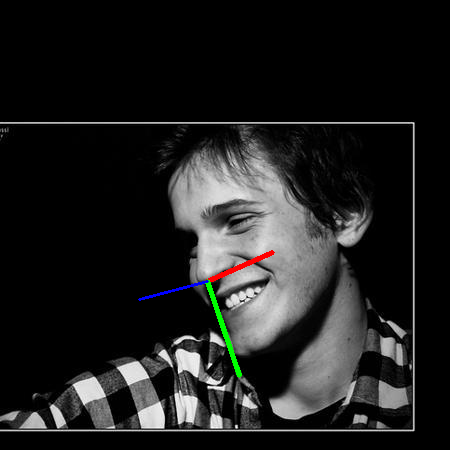

In [ ]:
# choosing random image from the testing data
rand_image = 'image00429'
# detecting face and extracting the points
faceModule = mediapipe.solutions.face_mesh
# loading image 
with faceModule.FaceMesh(static_image_mode=True) as faces:
  # loading the image
  image = cv2.imread('/content/AFLW2000/'+rand_image+'.jpg')
  # processing the face to extract the landmark points (468 point) for each x,y,z
  results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None: 
    # looping over the faces in the image
    for face in results.multi_face_landmarks:
        # initializing two lists to store the points for every face.
        x_array = []
        y_array = []
        # looping over the 468 points of x and y
        for landmark in face.landmark:
            x = landmark.x
            y = landmark.y
            # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
            shape = image.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            #Xs of face
            x_array.append(relative_x)
            #Ys of face
            y_array.append(relative_y)

        # converting the x anx y to numpy arrays
        x_array = np.array(x_array)
        y_array = np.array(y_array)

        # centering the points arround the 99th point 
        x_center = x_array - x_array[99]
        y_center = y_array - y_array[99]

        # computing the distance
        distance = np.linalg.norm(np.array((x_array[10],y_array[10])) - np.array((x_array[171],y_array[171])),axis = 0)
        x_norm = x_center / distance
        y_norm = y_center / distance

        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        features = np.hstack([x_norm,y_norm]).reshape(1,-1)

        # predicting the 3 angels to draw the axis on the image
        pred_pitch = m_gs_svr_pitch_be.predict(features)
        pred_yaw = m_gs_svr_yaw_be.predict(features)
        pred_roll = m_gs_svr_roll_be.predict(features)
        cv2_imshow(draw_axis(image,pred_pitch,pred_yaw,pred_roll,x_array[99],y_array[99]))

### Test the model on a video

In [ ]:
# loading the test video
%%capture
!git clone https://github.com/engmohamedmostafa2021/Head-Pose-Estimation

In [ ]:
# Create a VideoCapture object and read from input file
def Create_TestVideo(pitch_model,yaw_model,roll_model,path):
  cap = cv2.VideoCapture(path)
  width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # Check if camera opened successfully
  if (cap.isOpened()== False): 
      print("Error opening video file")
  #a list to store the frames of the video  
  video_array = []
  # Read until video is completed
  while(cap.isOpened()):   
    # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
        # loading image 
        with faceModule.FaceMesh(static_image_mode=True) as faces:
          # processing the face to extract the landmark points (468 point) for each x,y,z
          results = faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
          if results.multi_face_landmarks != None: 
            # looping over the faces in the image
            for face in results.multi_face_landmarks:
                # initializing two lists to store the points for every face.
                x_array = []
                y_array = []
                # looping over the 468 points of x and y
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                    shape = frame.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    #Xs of face
                    x_array.append(relative_x)
                    #Ys of face
                    y_array.append(relative_y)

                # converting the x anx y to numpy arrays
                x_array = np.array(x_array)
                y_array = np.array(y_array)

                # centering the points arround the 99th point 
                x_center = x_array - x_array[99]
                y_center = y_array - y_array[99]

                # computing the distance
                distance = np.linalg.norm(np.array((x_array[171],y_array[171])) - np.array((x_array[10],y_array[10])),axis = 0)
                x_norm = x_center / distance
                y_norm = y_center / distance

                # concatinating the x and y points to predict the labels (pitch,yaw,roll)
                features = np.hstack([x_norm,y_norm]).reshape(1,-1)

                # predicting the 3 angels to draw the axis on the image
                pred_pitch = pitch_model.predict(features)
                pred_yaw = yaw_model.predict(features)
                pred_roll = roll_model.predict(features)
                draw_axis(frame,pred_pitch,pred_yaw,pred_roll,x_array[99],y_array[99])
                # appending the result frames to the video_array list
                video_array.append(frame)
      else:
        break
  cap.release()  
  # Closes all the frames
  cv2.destroyAllWindows()
  print("Number of Detected Frames = ",len(video_array))
  # converting the frames to video
  out = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
  for i in range(len(video_array)):
    out.write(video_array[i])
  out.release()

In [ ]:
path = "/content/Head-Pose-Estimation/Video_for_Project.mp4" 
Create_TestVideo(m_gs_svr_pitch_be,m_gs_svr_yaw_be,m_gs_svr_roll_be,path)


Number of Detected Frames =  629


In [ ]:
from google.colab import files
files.download('/content/out.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>